<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Soziale Netzwerke Analysieren Projekt:<br> Raumsonden & Himmelskörper
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Flurina Riner, Patrick Schürmann, Si Ben Tran im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>

# 1 Setup & Libraries

Hier in diesem Abschnitt importieren wir die wichtigsten Libraries für unser Projekt.

In [1]:
# Reload modules
%load_ext autoreload
%autoreload 2

from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from scipy.stats import pearsonr

# 2 Explorative Datenanalyse

Bewertungskriterien:   
Explorative Analysen der verwendeten Daten (Missing Values, Verteilungen, Plausilitätsprüfungen), allfällige Transformationen und Bereinigen oder Ausschliessen von fehlerhaften Daten. Wurde  geprüft, ob die Daten mit den Quelldaten übereinstimmen.

## 2.1 Daten einlesen

In [2]:
lst_every_episode = []
graph_every_episode = []

for episode in range(1, 8):
    filename = f'data/Star Wars/starwars-episode-{episode}-interactions-allCharacters.json'
    with open(filename, 'r') as file:
        data = json.load(file)
        nodes = data['nodes']
        df_nodes = pd.DataFrame(nodes)
        df_nodes = df_nodes.reset_index(drop=False)
        df_nodes = df_nodes.rename(columns={"index": "ID"})
        edges = data['links']
        df_edges = pd.DataFrame(edges)
        lst_every_episode.append((df_nodes, df_edges))
        G = nx.Graph()
        for idx, row in df_nodes.iterrows():
            G.add_node(row['ID'], label=row['name'], size=row['value'], color=row['colour'])
        for idx, row in df_edges.iterrows():
            G.add_edge(row['source'], row['target'], weight=row['value'])
        graph_every_episode.append(G)

## 2.2 Fehlende Werte

## 2.3 Verteilungen der Daten

## 2.4 Plausibilitätsprüfungen

# 3 Netzwerkanalyse der ersten Episode

Die Funktion `plot_epsiode_network` erlaubt es uns ein beliebiges Netzwerk aus unseren Daten zu plotten.   
Die wichtigsten Parameter dabei sind `graph_list` (nimmt eine List von Graphen entgegen) und `episode_number` (die gewünschte Episode). 

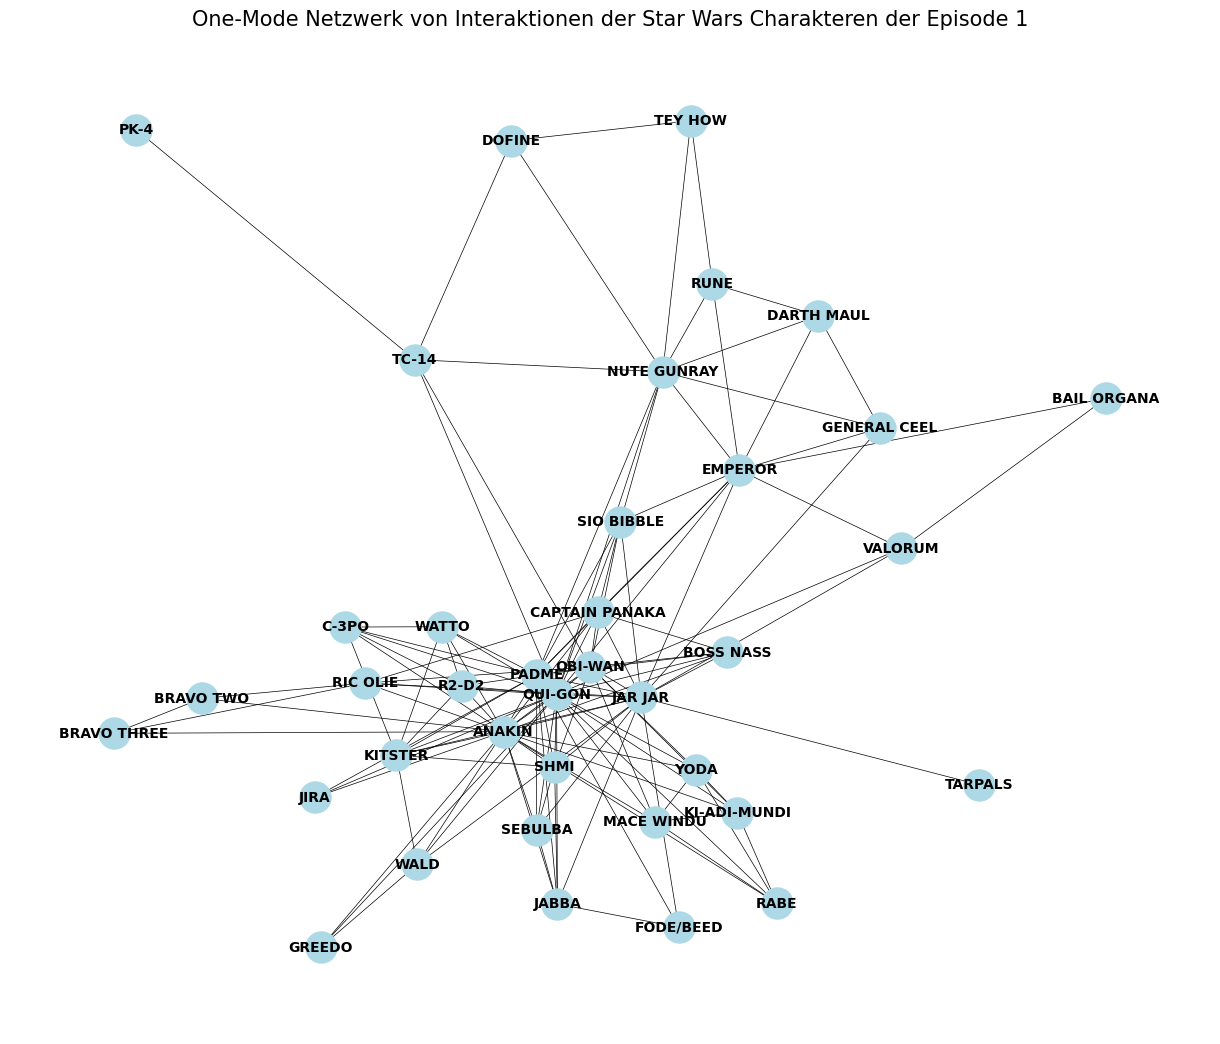

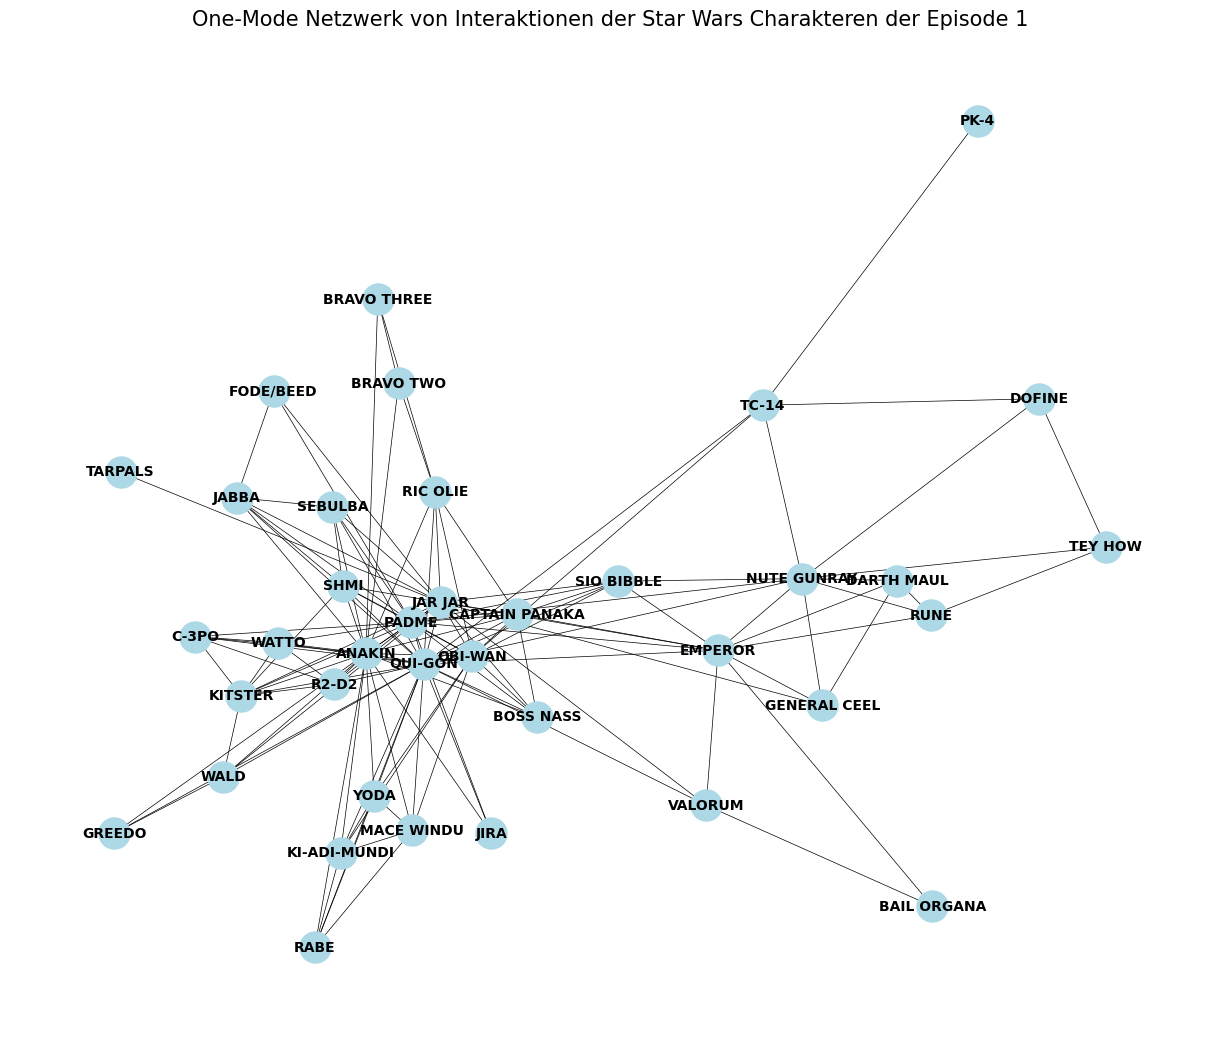

In [3]:
def plot_episode_network(graph, episode_number=None, node_colors='Lightblue'):
    if isinstance(graph, list):
        graph_episode = graph[episode_number - 1]
    else:
        graph_episode = graph
    
    labels = {node: data['label'] for node, data in graph_episode.nodes(data=True)}
    plt.figure(figsize=(12, 10))
    nx.draw(
        graph_episode,
        labels=labels,
        with_labels=True,
        node_color=node_colors,
        node_size=500,
        edge_color='black',
        font_size=10,
        font_weight='bold',
        width=0.5)
    plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode {episode_number}", fontsize=15)
    plt.show()

plot_episode_network(graph = graph_every_episode, 
                     episode_number = 1)

graph_first_episode = graph_every_episode[0]

plot_episode_network(graph = graph_first_episode, 
                     episode_number = 1)

## 3.1 Lassen sich Cluster/Communities erkennen oder gar erstellen?

Praktischerweise erlaubt es uns die Library `networkx` die Communities in einem Netzwerk durch die Methode `number_connected_coponents` zu erkennen. Da wir einen ungerichteten Graphen haben ist es nicht verwunderlich, dass wir nur eine Community erkennen können. Aus diesem Grund nutzen wir dann in einem zweiten Ansatz den Edge-Betweenness Clustering Algorithmus auch bekannt aus grivan-newman. Dieser Algorithmus erlaubt es uns die Nodes in Communities zu unterteilen, dies führt der Algorithmus indem er die Edge Betweenness berechnet und die Edge mit der höchsten Betweenness entfernt. Die Funktion hat als Rückgabewert eine Liste von Listen, wobei jede Liste eine Community darstellt.

Die Funktion `get_node_groups_grivan_newman` nutzt den Algorithmus von Grivan-Newman um die Nodes in Communities zu unterteilen, der Input ist der Graph selbst. Die Funktion gibt eine Liste von Listen zurück, wobei jede Liste eine Community darstellt.

Die Funktion `create_color_map` erstellt eine Liste von Farben, der Input ist der Graph selbst und die Liste von Communities. Die Funktion gibt eine Liste von Farben zurück, wobei jede Farbe einer Community entspricht.

Durch die beiden Funktionen `get_node_groups_grivan_newman` und `create_color_map` können wir dann anschliessend das Netzwerk mit der vorherhigen geschriebenen Funktion `plot_epsiode_network` plotten.

In [4]:
print("Anzahl Connected Components:", nx.number_connected_components(graph_first_episode))

print("Die Komponenten:")
for x in nx.connected_components(graph_first_episode):
    print(x)

Anzahl Connected Components: 1
Die Komponenten:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


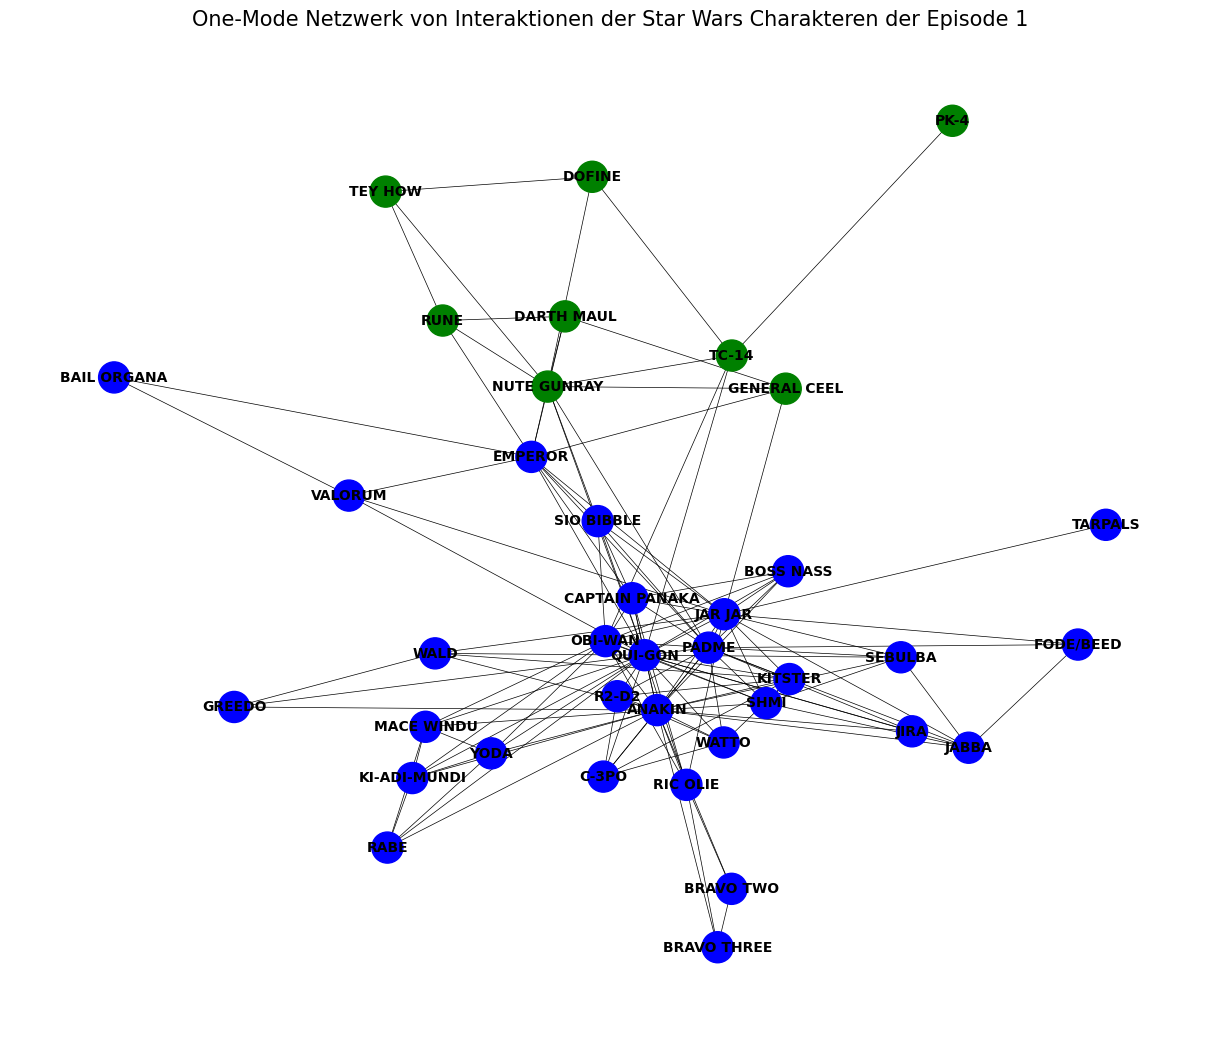

In [5]:
def get_node_groups_grivan_newman(graph, print_node_groups=False):
    labels = {node: data['label'] for node, data in graph.nodes(data=True)}
    communities = nx.community.girvan_newman(graph)
    node_groups = []
    for com in next(communities):
        node_groups.append(list(com))
    if print_node_groups:
        for i, group in enumerate(node_groups):
            print(f"Gruppe {i+1}:")
            for node in group:
                print(labels[node])
            print()
    return node_groups

node_first_groups = get_node_groups_grivan_newman(graph_first_episode, print_node_groups=False)

def create_color_map(graph, node_groups):
    color_map = []
    for node in graph:
        if node in node_groups[0]:
            color_map.append('blue')
        else:
            color_map.append('green')
    
    return color_map

color_first_map = create_color_map(graph_first_episode, node_first_groups)

plot_episode_network(graph = graph_first_episode,
                        episode_number = 1,
                        node_colors = color_first_map)


## 3.2 Gibt es Cliquen?

Wir wollen untersuchen, ob es innerhalb der ersten Episode Cliquen gibt. Wir verwenden dafür die k-Core Clique Methode und untersuchen unterschiedliche k-Werte.

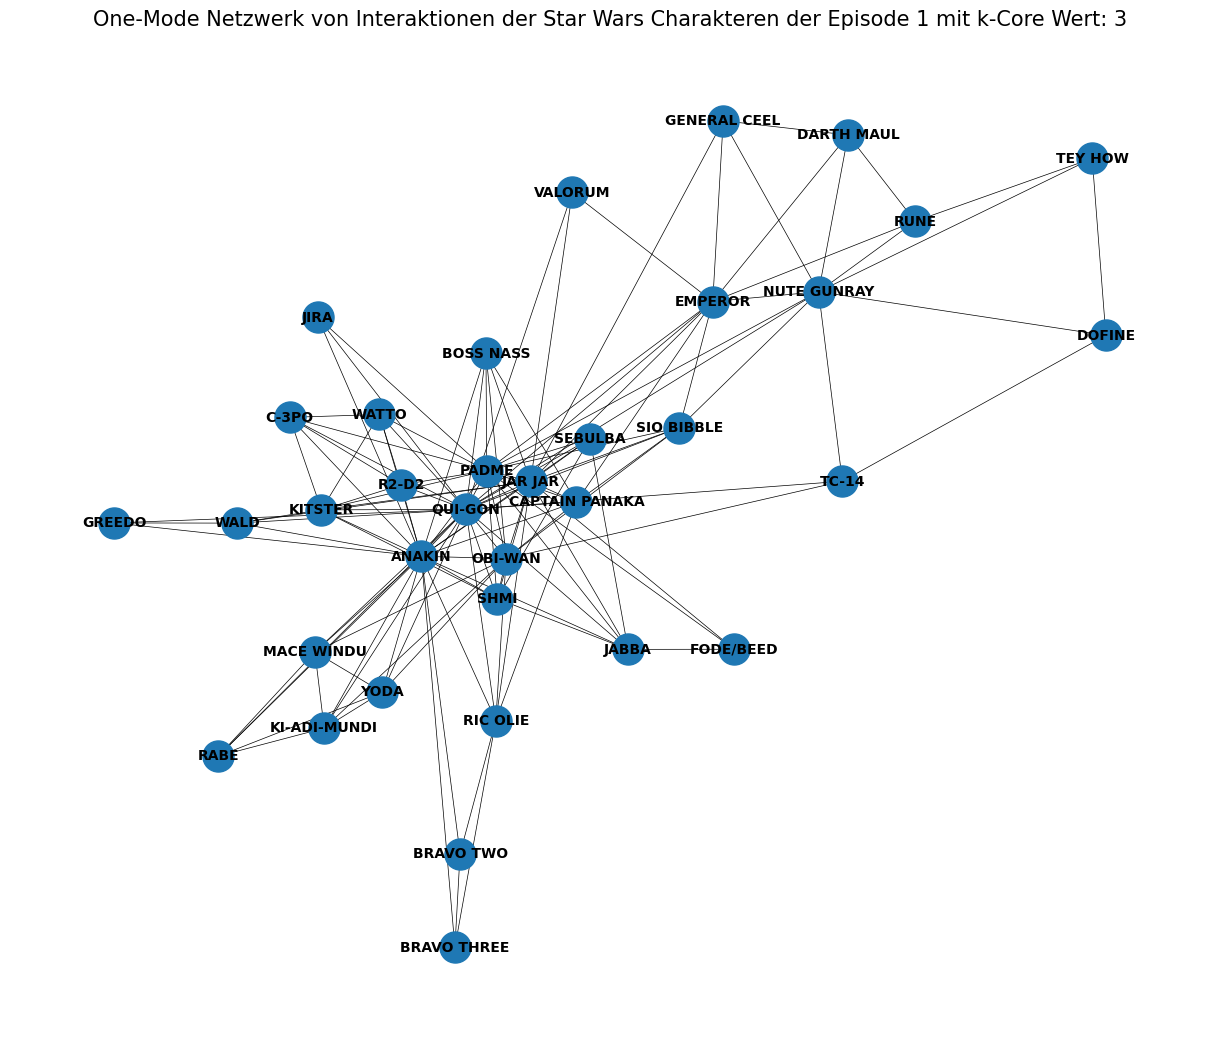

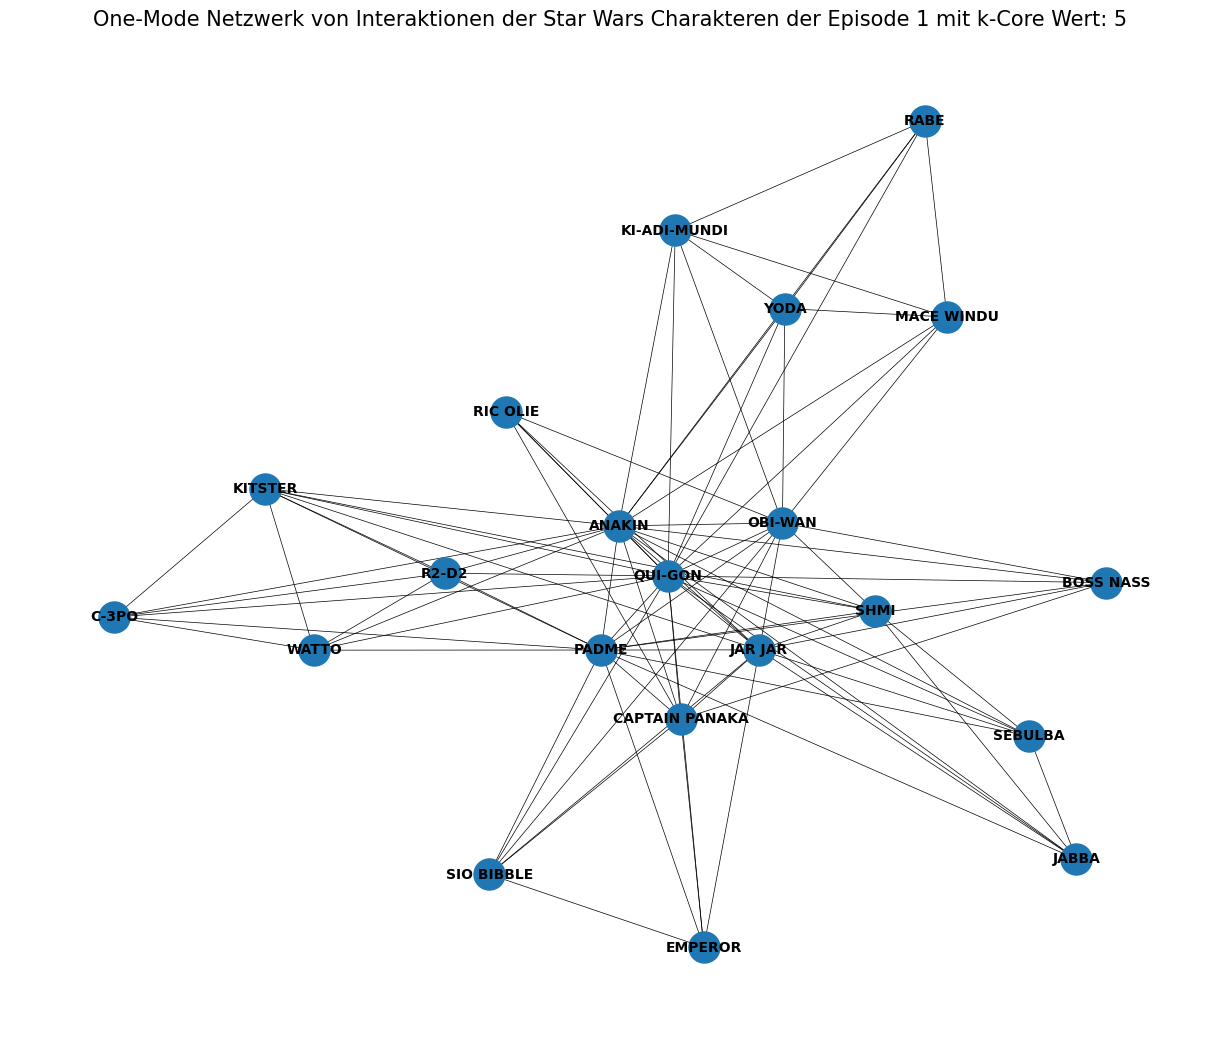

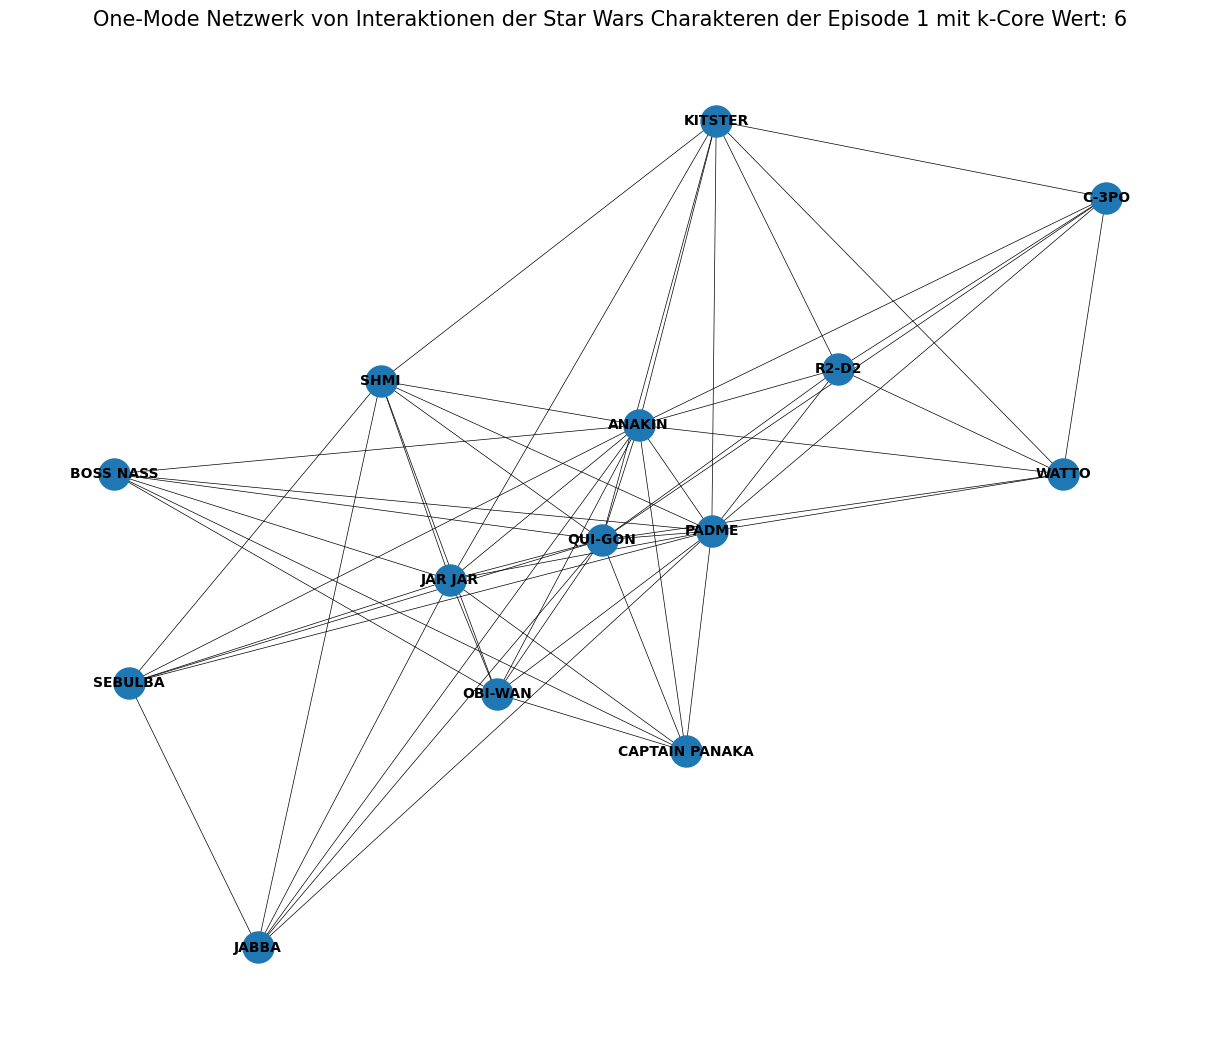

In [6]:
def plot_k_core_network(graph, episode_number, k_core_list):
    for k_value in k_core_list:
        k_core_cluster = nx.k_core(graph, k=k_value)
        labels = {node: data['label'] for node, data in k_core_cluster.nodes(data=True)}
        plt.figure(figsize=(12, 10))
        nx.draw(k_core_cluster, 
                labels=labels, 
                with_labels=True, 
                node_size=500, 
                edge_color='black', 
                font_size=10, 
                font_weight='bold',
                width=0.5)
        plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode {episode_number} mit k-Core Wert: {k_value}", fontsize=15)
        plt.show()

plot_k_core_network(graph = graph_first_episode,
                    episode_number = 1,
                    k_core_list = [3, 5, 6])

Der k-Core Wert 6 ist der höchste Wert, für den eine Clique gefunden werde konnte. Sie ist im letzten Plot ersichtlich. Die Clique besteht zu etwa der Hälfte aus wichtigen Personen der Episode und gesamten Reihe: Anakin, Padme, Obi-Wan, Qui-Gon, R2-D2 und C-3PO. Da diese Charakteren viel Kontakt zueinander haben, ist es deshalb zu erwarten, dass sie eine enge Clique bilden. 

## 3.3 Wie schnell würde sich die Geburt Yodas im Netzwerk verbreiten?

Da es bei Star Wars, wie der Name schon sagt, grösstenteils um Kriege geht, ist es wichtig zu wissen, wie schnell Informationen verbreitet werden. Eine Metrik, die dafür verwendet werden kann, ist der Diameter. Dabei handelt es sich um den längsten kürzesten Pfad im Netzwerk. Es handelt sich also um eine Entfernung und gibt an, wieviele Kanten maximal überwunden werden müssen.

In [7]:
nx.diameter(graph_first_episode)

4

Bei der ersten Episode beträgt der Diameter 4. Die Nachricht von einer Geburt Yodas, einem neuen Krieg etc. wird also nach spätestens vier Kanten alle Charakteren erreichen. Mangels vergleichswerten kann die Anzahl nur schwer interpretiert werden, uns kommt sie aber relativ vor.

Eine Überprüfung der Kennzahl Diameter ist im originalen Netzwerk schlecht möglich, da es recht unübersichtlich ist. Da wir gerade k-Core Clique erstellt haben, überprüfen wir die Metrik aber mit der Clique mit dem höchsten möglichen k-Wert (k=6).

In [8]:
nx.diameter(nx.k_core(graph_first_episode, k=6))

2

Der Diameter beträgt 2. In dem Netzwerk konnten wir keine grösseren kürzesten Pfad feststellen. Auftreten tut der Wert relativ viel, zum Beispiel zwischen den Charakteren Jabba-Kitster, Sebula-Anakin oder Qui-Gon-Watto.

## 3.4 Bridges und k-connectivity

Stabilität des Netzwerks durch Brdiges und k-connectivity

# 4 Netzwerkanalyse der Entwicklungen im Verlauf der Episoden

Überprüfung, welche Charakteren in welchen Filmen vorkommen.

In [9]:
def calculate_actor_centrality(graph_every_episode):
    dfs = []
    for episode in graph_every_episode:
        # Calculate degree centrality
        degree_dict = nx.degree(episode)
        name_degree_list = [(episode.nodes[node]['label'], degree) for node, degree in degree_dict]
        df = pd.DataFrame(name_degree_list, columns=['Actor', 'Degree Centrality'])
        # calculate normalized degree centrality
        normalized_degree_dict = nx.degree_centrality(episode)
        name_normalized_degree_list = [(episode.nodes[node]['label'], normalized_degree) for node, normalized_degree in normalized_degree_dict.items()]
        df['Normalized Degree Centrality'] = [normalized_degree for actor, normalized_degree in name_normalized_degree_list]
        # Calculate closeness centrality
        closeness_dict = nx.closeness_centrality(episode)
        name_closeness_list = [(episode.nodes[node]['label'], closeness) for node, closeness in closeness_dict.items()]
        df['Closeness Centrality'] = [closeness for actor, closeness in name_closeness_list]
        # Calculate betweenness centrality
        betweenness_dict = nx.betweenness_centrality(episode)
        name_betweenness_list = [(episode.nodes[node]['label'], betweenness) for node, betweenness in betweenness_dict.items()]
        df['Betweenness Centrality'] = [betweenness for actor, betweenness in name_betweenness_list]
        # Calculate Clustering Coefficient
        clustering_dict = nx.clustering(episode)
        name_clustering_list = [(episode.nodes[node]['label'], clustering) for node, clustering in clustering_dict.items()]
        df['Clustering Coefficient'] = [clustering for actor, clustering in name_clustering_list]
        # Create a column with the episode number
        df['Episode'] = graph_every_episode.index(episode) + 1
        dfs.append(df)
    df_degree_centrality = pd.concat(dfs, ignore_index=True)
    return df_degree_centrality

actor_centrality_all = calculate_actor_centrality(graph_every_episode)
display(actor_centrality_all)


Actor  Degree Centrality  Normalized Degree Centrality  \
0            R2-D2                  6                      0.162162   
1          QUI-GON                 26                      0.702703   
2      NUTE GUNRAY                 10                      0.270270   
3             PK-4                  1                      0.027027   
4            TC-14                  5                      0.135135   
..             ...                ...                           ...   
181      YOLO ZIFF                  4                      0.153846   
182  COLONEL DATOO                  1                      0.038462   
183      ELLO ASTY                  4                      0.153846   
184           JESS                  5                      0.192308   
185        NIV LEK                  4                      0.153846   

     Closeness Centrality  Betweenness Centrality  Clustering Coefficient  \
0                0.486842                0.000000                1.000000   
1                0.770833                0.322614                0.255385   
2                0.552239                0.125431                0.333333   
3                0.336364                0.000000                0.000000   
4                0.500000                0.073186                0.300000   
..                    ...                     ...                     ...   
181              0.433333                0.000000                1.000000   
182              0.298851                0.000000                0.000000   
183              0.433333                0.000000                1.000000   
184              0.440678                0.004615                0.700000   
185              0.433333                0.000000                1.000000   

     Episode  
0          1  
1          1  
2          1  
3          1  
4          1  
..       ...  
181        7  
182        7  
183        7  
184        7  
185        7  

[186 rows x 7 columns]

In [10]:
def plot_actor_metrics(dataframe, actors, metric_vis, plot_type="bar"):
    centrality_pick = dataframe[dataframe['Actor'].isin(actors)]
    if plot_type == "bar":
        fig = px.bar(centrality_pick, x="Episode", y=metric_vis, color="Actor", barmode="group")
    elif plot_type == "line":
        fig = px.line(centrality_pick, x="Episode", y=metric_vis, color="Actor")
    else:
        raise ValueError("Invalid plot_type. Use 'bar' or 'line'.")
    title = f'{metric_vis} for {", ".join(actors)}'
    fig.update_layout(title_text=title)
    fig.show()

Wie es scheint, kommen nur R2-D2 und C3PO in allen Episoden vor. Wir werden deshalb die Vergleiche anhand dieser beider Charakteren durchführen.

## 4.1 Wie entwickeln sich die Wichtigkeiten einzelner Charakteren/Gruppen im Verlauf der Filme?

### 4.1.1 Degree-Zentralität

In [11]:
plot_actor_metrics(actor_centrality_all, actors = ['R2-D2', 'C-3PO'], metric_vis='Degree Centrality', plot_type='line')

### 4.1.2 Closeness Zentralität

In [12]:
plot_actor_metrics(actor_centrality_all, actors = ['R2-D2', 'C-3PO'], metric_vis='Closeness Centrality', plot_type='line')

### 4.1.3 Betweenness Zentralität

In [13]:
plot_actor_metrics(actor_centrality_all, actors = ['R2-D2', 'C-3PO'], metric_vis='Betweenness Centrality', plot_type='line')

In [14]:
plot_actor_metrics(actor_centrality_all, actors = ['R2-D2', 'C-3PO', 'ANAKIN'], metric_vis='Normalized Degree Centrality', plot_type='line')

In [15]:
#to-do: - für jede Episode die Person mit dem höchsten Betweenness-Centrality Wert angeben.
#       - Wie gross wäre das Problem im Film, wo R2-D2 verloren ging, gewesen.

# Diskussion: R2-D2 macht zwar wichtige Handlungen (z.B. Millenium Falcon reparieren), aber das sieht man hier bei der Kommunikation nicht. Diese Wichtigkeit kann in dieser Analyse vom sozialen Netzwerk nicht eruiert werden.

Gerne hätten wir auch die Prestige berechnet, da es sich bei unseren Netzwerken um ungerichtete handelt, ist dies leider nicht möglich.

# 5 Entwicklung der Film Netzwerke
## 5.1 Wie entwickeln sich die Zentralisierung der Netzwerke?

Metriken berechnen zu jedem Film und Visualisieren


 

## 5.1 Alle Netzwerke Visualisieren

Bevor wir mit den Berechnungen der Metriken anfangen, visualisieren wir alle Netzwerke, um uns einen Überblick zu verschaffen.

Die Funktion `plot_all_networks` nimmt als Parameter eine Liste von Graphen entgegen und visualisiert diese in einem Grid. Wir können somit mit dieser Funktion beliebige Episoden nebeneinander visuzalisieren. 

Durch die Visualisierung erkennen wir, dass die Anzahl an Charakteren unterschiedlich schwankt. Episode 5 weisst deutlich weniger Anzahl an Charakteren auf als bei Episode 1. 

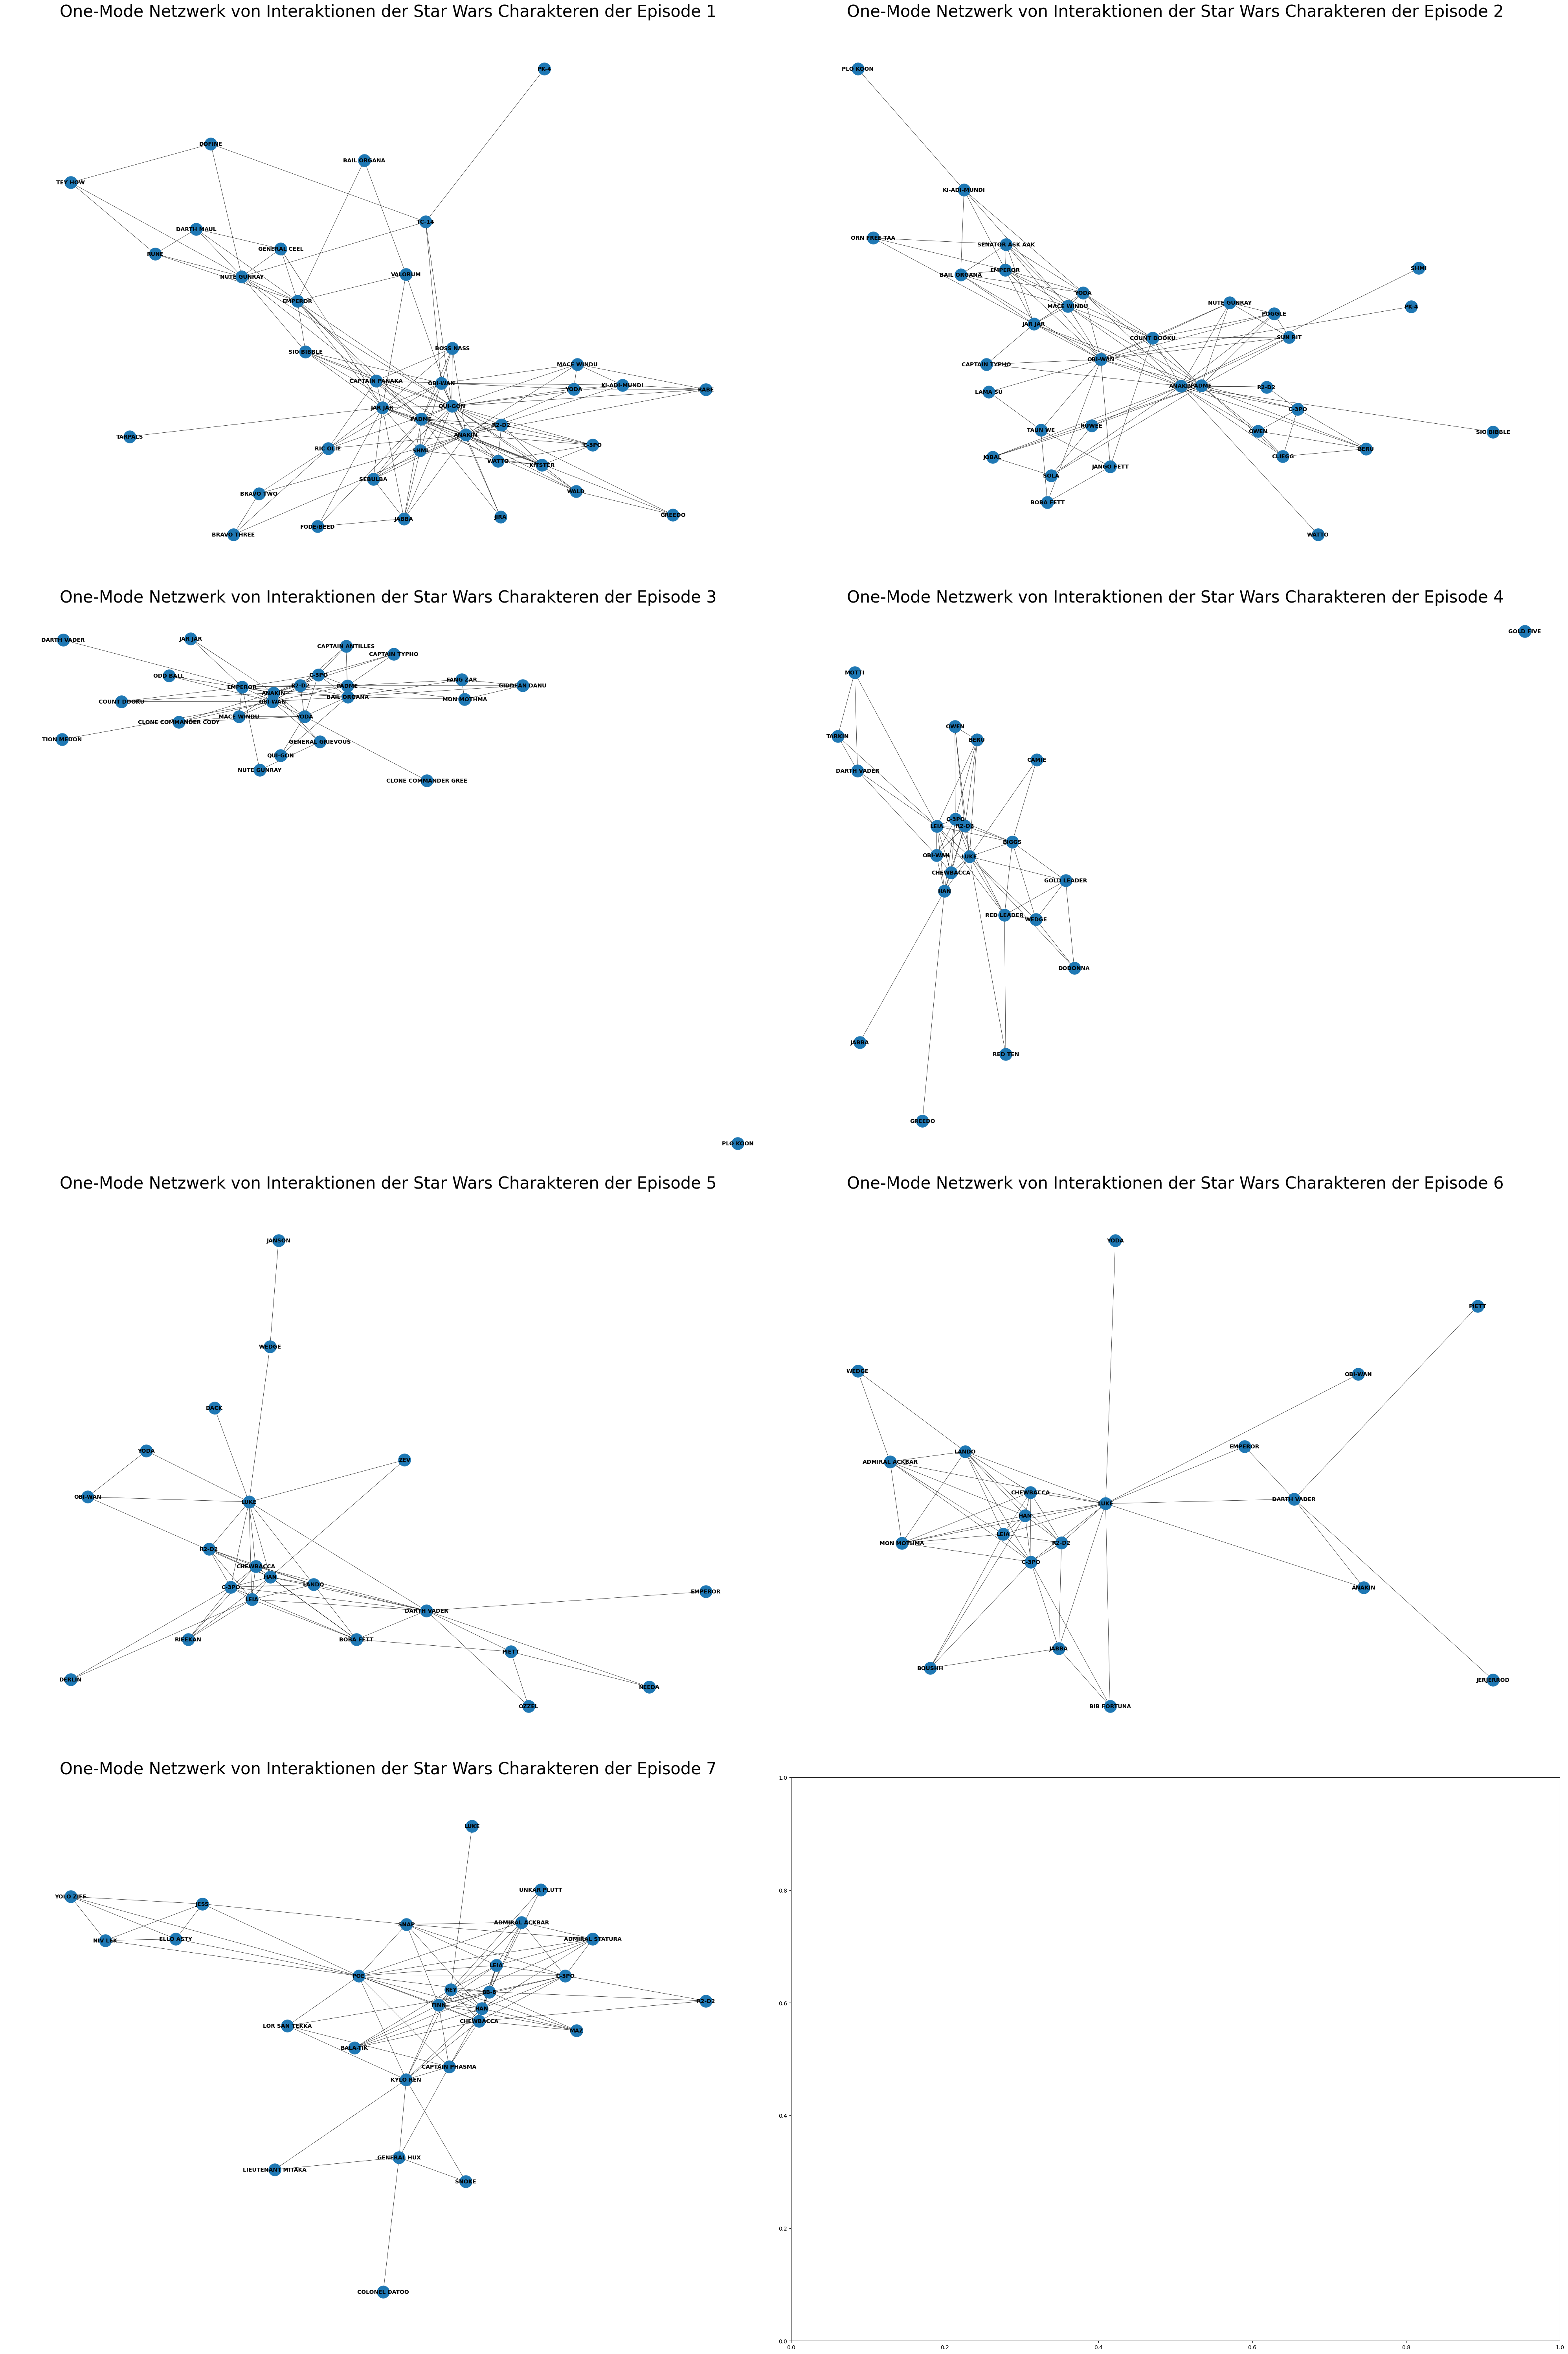

In [16]:
def plot_all_networks(episode_numbers, graph_data_list, figsize=(17, 7)):
    num_episodes = len(episode_numbers)
    num_columns = 2  

    num_rows = (num_episodes + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(figsize[0] * num_columns, figsize[1] * num_rows))

    for i, episode_number in enumerate(episode_numbers):
        if episode_number < 1 or episode_number > len(graph_data_list):
            print(f"Episode {episode_number} existiert nicht.")
            continue

        selected_graph = graph_data_list[episode_number - 1]

        labels = {node: data['label'] for node, data in selected_graph.nodes(data=True)}

        row = i // num_columns
        col = i % num_columns

        ax = axes[row, col] if num_rows > 1 else axes[col]
        plt.sca(ax)

        plt.title(f"One-Mode Netzwerk von Interaktionen der Star Wars Charakteren der Episode {episode_number}", fontsize=figsize[0] * 1.5)

        nx.draw(selected_graph,
                labels=labels,
                with_labels=True,
                node_size=500,
                edge_color='black',
                font_size=10,
                font_weight='bold',
                width=0.5)

    plt.tight_layout()
    plt.show()

plot_all_networks(episode_numbers = [1, 2, 3, 4, 5, 6, 7],
                 graph_data_list=graph_every_episode, figsize=(20, 15))

## 5.2 Funktion für Berechnung der Netzwerk Metriken

In [17]:
class NetworkCentrality():
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.actors = self.dataframe['Actor'].unique()
        self.episodes = self.dataframe['Episode'].unique()

    # calculate n for each episode
    def _n_actor_for_episode(self, episode):
        return len(self.dataframe[self.dataframe['Episode'] == episode]['Actor'].unique())
    
    # get maximum value of centrality for each episode
    def _max_centrality_for_episode(self, episode, centrality):
        return self.dataframe[self.dataframe['Episode'] == episode][centrality].max()
    
    # get degree centrality for each episode
    def _degree_centrality(self, episode):
        return self.dataframe[self.dataframe['Episode'] == episode]['Degree Centrality']
    
    # get closeness centrality for each episode
    def _closeness_centrality(self, episode):
        return self.dataframe[self.dataframe['Episode'] == episode]['Closeness Centrality']
    
    # get betweenness centrality for each episode
    def _betweenness_centrality(self, episode):
        return self.dataframe[self.dataframe['Episode'] == episode]['Betweenness Centrality']
    
    # calculate Degree Network Centrality 
    def degree_network_centrality(self, episode):
        """
        implementation based on san script michael henninger
        """
        c_max = self._max_centrality_for_episode(episode, 'Degree Centrality')
        c = self._degree_centrality(episode)
        n = self._n_actor_for_episode(episode)
        return (np.sum(c_max - c)) / ((n - 1) * (n - 2))
    
    # calculate Closeness Network Centrality
    def closeness_network_centrality(self, episode):
        """
        implementation based on san script michael henninger,
        closnes centrality must be normalized!
        """
        c_max = self._max_centrality_for_episode(episode, 'Closeness Centrality')
        c = self._closeness_centrality(episode)
        n = self._n_actor_for_episode(episode)
        return (np.sum(c_max - c)) / ((n - 2) / 2)
    
    # calculate Betweenness Network Centrality
    def betweenness_network_centrality(self, episode):
        """
        implementation based on san script michael henninger
        Betweenness centrality must be normalized!
        """
        c_max = self._max_centrality_for_episode(episode, 'Betweenness Centrality')
        c = self._betweenness_centrality(episode)
        n = self._n_actor_for_episode(episode)
        return (np.sum(c_max - c)) / (n - 1)
    
    def calculate_network_centrality(self):
        """
        implementation based on san script michael henninger
        """
        dfs = []
        for episode in self.episodes:
            df_episode = pd.DataFrame({'Episode': [episode],
                                    'Degree Network Centrality': [self.degree_network_centrality(episode)],
                                    'Closeness Network Centrality': [self.closeness_network_centrality(episode)],
                                    'Betweenness Network Centrality': [self.betweenness_network_centrality(episode)]})
            dfs.append(df_episode)
        
        df = pd.concat(dfs, ignore_index=True)
        return df
    
    # visualize network centrality
    def plot_network_centrality(self, plot_type="bar", centrality_to_show=["Degree Network Centrality", "Closeness Network Centrality", "Betweenness Network Centrality"]):
        df = self.calculate_network_centrality()
        centrality_to_show = centrality_to_show
        if plot_type == "bar":
            fig = px.bar(df, x="Episode", y=centrality_to_show, barmode="group", title=f"Network Centrality for {', '.join(centrality_to_show)}")
            fig.show()
        elif plot_type == "line":
            fig = px.line(df, x="Episode", y=centrality_to_show)
            fig.show()
        


## 5.2.1 Initialisierung der Klasse

In [18]:
# Initliaze NetworkCentrality class
network_centrality = NetworkCentrality(actor_centrality_all)

# calculate network centrality for each episode
network_centrality_df = network_centrality.calculate_network_centrality()
display(network_centrality_df)

Episode  Degree Network Centrality  Closeness Network Centrality  \
0        1                   0.539039                      0.594011   
1        2                   0.494960                      0.519780   
2        3                   0.398551                      0.475134   
3        4                   0.500000                      0.593563   
4        5                   0.373684                      0.455374   
5        6                   0.555556                      0.646740   
6        7                   0.381538                      0.399375   

   Betweenness Network Centrality  
0                        0.299801  
1                        0.357497  
2                        0.151207  
3                        0.294207  
4                        0.378344  
5                        0.572894  
6                        0.265644

### 5.2.2 Degree Zentralisierung 

In [19]:
# visualize Degree Network Centrality for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Degree Network Centrality"])

### 5.2.3 Closeness 

In [20]:
# visualize Closeness Network Centrality for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Closeness Network Centrality"])

### 5.2.3 Betweenness Zentralisierung 

In [21]:
# visualize Betweenness Network Centrality for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Betweenness Network Centrality"])

## 5.3 Alle Netzwerk Zentralisierungs Metriken für alle Episoden

In [22]:
# visualize all network centrality metrics for each episode
network_centrality.plot_network_centrality(plot_type="line", centrality_to_show=["Degree Network Centrality", "Closeness Network Centrality", "Betweenness Network Centrality"])

## 5.2 Netzwerk Metriken





### 5.2.1 Graph Density

Dokuementation von Graph Density in NetworkX: https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html

In [23]:
def calculate_graph_density(graph_every_episode):
    dfs = []
    for G_episode in graph_every_episode:
        density = nx.density(G_episode)
        dfs.append(density)
    df_density = pd.DataFrame(dfs, columns=['Density'])
    df_density = df_density.reset_index(drop=False).rename(columns={"index": "Episode"}).add(1)
    return df_density

df_density = calculate_graph_density(graph_every_episode)
display(df_density)

fig = px.line(df_density, x="Episode", y="Density")
fig.update_layout(title_text="Dichte der Star Wars Episode Netzwerke")
fig.show()


Episode   Density
0        1  1.192034
1        2  1.191288
2        3  1.216667
3        4  1.259740
4        5  1.261905
5        6  1.289474
6        7  1.262108

### 5.2.2 Cluster Coefficient einzelner Nodes

In [24]:
display("Cluster Coefficient for each node:", actor_centrality_all[["Actor", "Episode", "Clustering Coefficient"]])

'Cluster Coefficient for each node:'

Actor  Episode  Clustering Coefficient
0            R2-D2        1                1.000000
1          QUI-GON        1                0.255385
2      NUTE GUNRAY        1                0.333333
3             PK-4        1                0.000000
4            TC-14        1                0.300000
..             ...      ...                     ...
181      YOLO ZIFF        7                1.000000
182  COLONEL DATOO        7                0.000000
183      ELLO ASTY        7                1.000000
184           JESS        7                0.700000
185        NIV LEK        7                1.000000

[186 rows x 3 columns]

In [25]:
plot_actor_metrics(actor_centrality_all, actors = ['R2-D2', 'C-3PO'], metric_vis='Clustering Coefficient', plot_type='line')

### 5.2.3 Cluster Coefficient der Netzwerke 

In [26]:
def average_clustering_coefficient(graph_every_episode):
    dfs = []
    for G_episode in graph_every_episode:
        avg_clustering_coefficient = nx.average_clustering(G_episode)
        dfs.append(avg_clustering_coefficient)
    df_avg_clustering_coefficient = pd.DataFrame(dfs, columns=['Clustering Coefficient'])
    df_avg_clustering_coefficient = df_avg_clustering_coefficient.reset_index(drop=False).rename(columns={"index": "Episode"}).add(1)
    return df_avg_clustering_coefficient

df_avg_clustering_coefficient = average_clustering_coefficient(graph_every_episode)
display("Average Cluster Coefficient for each Episode:", df_avg_clustering_coefficient)

fig = px.line(df_avg_clustering_coefficient, x="Episode", y="Clustering Coefficient")
fig.update_layout(title_text="Durchschnittlicher Clustering Coefficient der Star Wars Episode Netzwerke")
fig.show()


'Average Cluster Coefficient for each Episode:'

Episode  Clustering Coefficient
0        1                1.711575
1        2                1.677909
2        3                1.599564
3        4                1.663872
4        5                1.628582
5        6                1.609444
6        7                1.701772

# 6 Link-Prediction

Bei der Link Prediction wird versucht vorherzusagen, welche Charakteren eine direkte Verbindung (also Kante) aufbauen sollten.

Für die Link Predictions verwenden wir die drei Methoden Jaccard Coefficient, Preferential Attachment und Resource Allocation. Wir haben sie ausgewählt, weil sie einerseits unterschiedliche Berechnungsmethoden haben und andererseits, weil sie komplexer als z.B. die Common Neighbours Methode sind.

Aufgrund der unterschiedlichen Berechnungsmethoden wird es interessant sein, zu sehen, wie unterschiedlich die Link Predictions sind. Zusätzlich werden wir einzelne Predictions genauer anschauen und so weit möglich die Berechnung von Networkx überprüfen.

Zum Schluss werden wir auch eine Methode für eine mögliche Anwendung bestimmen.

In [27]:
lst_prediction_methods = ["jaccard_coefficient", "preferential_attachment", "resource_allocation_index"]
lst_predictions = []

for method in lst_prediction_methods:
    method = getattr(nx, method)
    predictions = method(graph_first_episode)
    lst_predictions.append(list(predictions))

labels = {node: data['label'] for node, data in graph_first_episode.nodes(data=True)}

for method_name, method_predictions in zip(lst_prediction_methods, lst_predictions):
    sorted_link_pred = sorted(method_predictions, key=lambda x: x[2], reverse=True)
    top_5_recommendations = sorted_link_pred[:5]

    top_5_recommendations_names = [(labels[u], labels[v], p) for u, v, p in top_5_recommendations]

    print(f"Top 5 Empfehlungen mit {method_name}:")
    for u, v, p in top_5_recommendations_names:
        print(u, "und", v, "Wert:", round(p, 3))
    print()


Top 5 Empfehlungen mit jaccard_coefficient:
SIO BIBBLE und BOSS NASS Wert: 0.625
BOSS NASS und RIC OLIE Wert: 0.625
RUNE und GENERAL CEEL Wert: 0.6
BOSS NASS und SHMI Wert: 0.556
R2-D2 und JIRA Wert: 0.5

Top 5 Empfehlungen mit preferential_attachment:
EMPEROR und ANAKIN Wert: 253
NUTE GUNRAY und ANAKIN Wert: 230
NUTE GUNRAY und JAR JAR Wert: 180
SIO BIBBLE und ANAKIN Wert: 161
OBI-WAN und EMPEROR Wert: 143

Top 5 Empfehlungen mit resource_allocation_index:
OBI-WAN und RABE Wert: 0.582
NUTE GUNRAY und JAR JAR Wert: 0.578
RUNE und GENERAL CEEL Wert: 0.441
NUTE GUNRAY und OBI-WAN Wert: 0.437
TC-14 und TEY HOW Wert: 0.433



Für jede der drei Methoden wurden die Top fünf Empfehlungen angezeigt. Wir stellen fest, dass die Methoden recht unterschiedliche Resultate generiert haben. Zwar kommen häufig ähnliche Charakteren vor, doch meistens in anderen Kombinationen. Die Wahl der Methode hat also einen wichtigen Einfluss auf die erstellten Predictions.

Folgend werden wir die Top-Empfehlungen der einzelnen Methoden genauer anschauen.

In [28]:
def top_n_characters(lst_prediction_methods, lst_predictions, index, n_characters, top_n_pred):
    method_name = lst_prediction_methods[index]
    method_predictions = lst_predictions[index]

    sorted_link_pred = sorted(method_predictions, key=lambda x: x[2], reverse=True)
    top_n_recommendations = sorted_link_pred[:top_n_pred]

    char_counter = Counter()
    for u, v, _ in top_n_recommendations:
        char_counter[labels[u]] += 1
        char_counter[labels[v]] += 1

    top_n_chars = char_counter.most_common(n_characters)

    print(f"Top {n_characters} am häufigsten empfohlene Charaktere in den Top {top_n_pred} Empfehlungen mit {method_name}:")
    for char, count in top_n_chars:
        print(f"{char}: {count} Mal")

#### 6.1 Jaccard Coefficient

In [29]:
top_n_characters(lst_prediction_methods, lst_predictions, 0, 7, 30)

print()
print("Untersuchung einzelner Top Predictions:")

print()
print("Anzahl Nachbarn von Sio Bibble:", nx.degree(graph_first_episode, 11), "und von Boss Nass:", nx.degree(graph_first_episode, 14))
print("Nachbarn von Sio Bibble:", sorted(graph_first_episode.neighbors(11)))
print("Nachbarn von Boss Nass:", sorted(graph_first_episode.neighbors(14)))
print("Anzahl gemeinsamer Nachbarn:", len(sorted(nx.common_neighbors(graph_first_episode, 11, 14))))

print()
print("Anzahl Nachbarn von R2-D2:", nx.degree(graph_first_episode, 0), "und von Jira:", nx.degree(graph_first_episode, 20))
print("Nachbarn von R2-D2:", sorted(graph_first_episode.neighbors(0)))
print("Nachbarn von Jira:", sorted(graph_first_episode.neighbors(20)))
print("Anzahl gemeinsamer Nachbarn:", len(sorted(nx.common_neighbors(graph_first_episode, 0, 20))))

Top 7 am häufigsten empfohlene Charaktere in den Top 30 Empfehlungen mit jaccard_coefficient:
BOSS NASS: 7 Mal
JIRA: 7 Mal
SHMI: 6 Mal
SIO BIBBLE: 4 Mal
SEBULBA: 4 Mal
WALD: 4 Mal
R2-D2: 3 Mal

Untersuchung einzelner Top Predictions:

Anzahl Nachbarn von Sio Bibble: 7 und von Boss Nass: 6
Nachbarn von Sio Bibble: [1, 2, 5, 9, 10, 12, 15]
Nachbarn von Boss Nass: [1, 5, 10, 12, 15, 18]
Anzahl gemeinsamer Nachbarn: 5

Anzahl Nachbarn von R2-D2: 6 und von Jira: 3
Nachbarn von R2-D2: [1, 15, 17, 18, 22, 24]
Nachbarn von Jira: [1, 15, 18]
Anzahl gemeinsamer Nachbarn: 3


Boss Nass und Jira werden mit je sieben Nennungen am häufigsten in den Top 30 Empfehlungen genannt. Wie wir bereits früher festgestellt haben, sind das Charakteren mit eher weniger Nachbarn. Entsprechend ist es vermutlich wahrscheinlicher, dass sie mit anderen Charakteren starke Übereinstimmungen der Nachbarn haben, was einen höheren Koeffizienten ergibt.

Bei der Analyse der ersten Prediction (Sio Bibble und Boss Nass) stellen wir fest, dass sie sieben und sechs Nachbarn haben, fünf davon sind gemeinsam. Dividieren wir diesen Wert durch acht, der Anzahl unterschiedlicher Nachbarn des Paars, erhalten wir den Koeffizient 0.625. Diesen Wert hat auch Networkx berechnet.

Bei der fünften Empfehlung (R2-D2 und Jira) gibt es nur drei gemeinsame Nachbarn, die sechs unterschiedlicher Nachbarn gegenüber stehen. Entsprechend ist der Koeffizient mit 0.5 tiefer.

## 6.2 Preferential Attachment

In [30]:
top_n_characters(lst_prediction_methods, lst_predictions, 1, 7, 30)

print()
print("Untersuchung einzelner Top Predictions:")
print()
print("Anzahl Nachbarn von Emperor:", nx.degree(graph_first_episode, 9), "und von Anakin:", nx.degree(graph_first_episode, 18))
print("Multiplikation der Anzahl Nachbarn:", nx.degree(graph_first_episode, 9) * nx.degree(graph_first_episode, 18))
print()
print("Anzahl Nachbarn von Obi-Wan:", nx.degree(graph_first_episode, 5), "und von Emperor:", nx.degree(graph_first_episode, 9))
print("Multiplikation der Anzahl Nachbarn:", nx.degree(graph_first_episode, 5) * nx.degree(graph_first_episode, 9))

Top 7 am häufigsten empfohlene Charaktere in den Top 30 Empfehlungen mit preferential_attachment:
ANAKIN: 8 Mal
JAR JAR: 8 Mal
NUTE GUNRAY: 5 Mal
OBI-WAN: 4 Mal
PADME: 4 Mal
EMPEROR: 3 Mal
KITSTER: 3 Mal

Untersuchung einzelner Top Predictions:

Anzahl Nachbarn von Emperor: 11 und von Anakin: 23
Multiplikation der Anzahl Nachbarn: 253

Anzahl Nachbarn von Obi-Wan: 13 und von Emperor: 11
Multiplikation der Anzahl Nachbarn: 143


Anakin und Jar Jar werden mit je acht Nennungen am häufigsten in den Top 30 Empfehlungen genannt. Das sind beides Charakteren mit einer relativ hohen Anzahl Nachbarn. Aufgrund der Berechnungsweise der Methode ist es zu erwarten, dass solche Charakteren häufig empfohlen werden. Denn mögliche Predictions mit ihnen bekommen schneller einen hohen Koeffizienten.

Die Analyse der Top Empfehlung (Emperor und Anakin) zeigt, dass das vorgeschlagene Paar 13 und 23 Nachbarn hat. Multipliziert ergibt das einen Wert von 253, was auch Networkx berechnet hat. Bei der fünften Empfehlung (Obi-Wan und Emperor) beträgt der Koeffizient bereits nur noch 143.

## 6.3 Resource Allocation

In [31]:
top_n_characters(lst_prediction_methods, lst_predictions, 2, 7, 30)

print()
print("Untersuchung einzelner Top Predictions:")
print()
print("Gemeinsame Nachbarn von Obi-Wan und Rabe:")
print(sorted(nx.common_neighbors(graph_first_episode, 5, 33)))
print("Anzahl der Nachbarn dieser Nachbarn:", graph_first_episode.degree(sorted(nx.common_neighbors(graph_first_episode, 5, 33))))
print("Inverse dieser Anzahl:", [round(1 / graph_first_episode.degree(neighbor), 5) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 5, 33)) if graph_first_episode.degree(neighbor) > 0])
print("Summe der Inversen:", round(sum(1 / graph_first_episode.degree(neighbor) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 5, 33)) if graph_first_episode.degree(neighbor) > 0), 3))
print()
print("Gemeinsame Nachbarn von TC-14 und Tey How:")
print(sorted(nx.common_neighbors(graph_first_episode, 4, 8)))
print("Anzahl der Nachbarn dieser Nachbarn:", graph_first_episode.degree(sorted(nx.common_neighbors(graph_first_episode, 4, 8))))
print("Inverse dieser Anzahl:", [round(1 / graph_first_episode.degree(neighbor), 5) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 4, 8)) if graph_first_episode.degree(neighbor) > 0])
print("Summe der Inversen:", round(sum(1 / graph_first_episode.degree(neighbor) for neighbor in sorted(nx.common_neighbors(graph_first_episode, 4, 8)) if graph_first_episode.degree(neighbor) > 0), 3))

Top 7 am häufigsten empfohlene Charaktere in den Top 30 Empfehlungen mit resource_allocation_index:
OBI-WAN: 6 Mal
JAR JAR: 4 Mal
EMPEROR: 4 Mal
BOSS NASS: 4 Mal
KITSTER: 4 Mal
NUTE GUNRAY: 3 Mal
TEY HOW: 3 Mal

Untersuchung einzelner Top Predictions:

Gemeinsame Nachbarn von Obi-Wan und Rabe:
[1, 18, 30, 31, 32]
Anzahl der Nachbarn dieser Nachbarn: [(1, 26), (18, 23), (30, 6), (31, 6), (32, 6)]
Inverse dieser Anzahl: [0.03846, 0.04348, 0.16667, 0.16667, 0.16667]
Summe der Inversen: 0.582

Gemeinsame Nachbarn von TC-14 und Tey How:
[2, 6]
Anzahl der Nachbarn dieser Nachbarn: [(2, 10), (6, 3)]
Inverse dieser Anzahl: [0.1, 0.33333]
Summe der Inversen: 0.433


Obi-Wan wird mit sechs Nennungen am häufigsten in den Top 30 Empfehlungen genannt. Eine Bestätigung der Top-Charakteren lässt sich nur schwer begründen. Zwar haben einige der Top Charakteren, wie Obi-Wan und Jar Jar, viele Nachbarn, doch hängt es bei dieser Methode auch davon ab, wieviele Nachbarn die gemeinsamen Nachbarn haben.

Bei der Analyse der obenstehenden Top 5 Empfehlungen fällt auf, dass bei der ersten Empfehlungen (Obi-Wan und Rabe) deren gemeinsamer Nachbarn (Qui-Gon, Anakin, Mace Windu, Ki-Adi-Mundi und Yoda) teilweise viele Nachbarn haben. Dank der Nachberechunung können wir aufzeigen, dass dank der drei Nachbarn mit je nur sechs Nachbarn (Inverse 0.167) der Koeffizient mit 0.582 relativ hoch ist. Zum Vergleich hat die fünften Empfehlung (TC-14 und Tey How) nur zwei gemeinsame Nachbarn und trotzdem einen Koeffizienten von 0.433, weil einer der Nachbarn nur drei Nachbarn hat. Entsprechend wird es trotz nur zweier Nachbarn als Wahrscheinlich erachtet, dass sich TC-14 und Tey How kennen.

Zusammengefasst wurde unsere Erwartung, dass unterschiedliche Berechnungsmethoden unterschiedliche Resultate liefern, bestätigt. Die Wahl der Methode ist also zentral für eine gute Prediction. Da in Star Wars die Charakteren, deren Ziel, Aufgaben, Herkunft und Weltansichten zum Teil sehr unterschiedlich sind, würden wir aus unserer drei Methoden Jaccard Coefficient verwenden. Da innerhalb von Communities in der Regel viele Verbindungen bestehen, würden so z.B. innerhalb des Jedi-Ordens neue Kontakte vorgeschlagen. Denkbar wäre auch eine Metrik, die entweder Communities (z.B. Soundarajan Hopcroft) oder Kontakte zu wichtigen Charakteren stärker berücksichtigt.

# 7 Diffusion 
mal luege was mir da machet

# 8 Hypothesentest

Wir untersuchen, ob der Degree der Charakteren mit der Anzahl Szenen, in denen sie vorkommen, zusammenhängt. Wir führen dazu einen monadischen Hypothesentest durch, die Hypothese lautet: "In der ersten Episode gibt es einen Zusammenhang zwischen dem Degree von Charakteren und der Anzahl Szenen, in denen sie ersichtlich sind." Wir definieren dazu eine Irrtumswahrscheinlichkeit von 0.05. Ist der p-Wert tiefer, bestätigen wir unsere Hypothese, ansonsten gibt es keinen Zusammenhang.

Im ersten Schritt berechnen wir den Degree und extrahieren die Anzahl Szenen, in denen die Charakteren vorkommen. Die Anzahl Szenen ist bereits im Datensatz von Kaggle enthalten. Danach berechnen wir die originale Pearson Korrelation.

Die originale Korrelation beträgt: 0.893


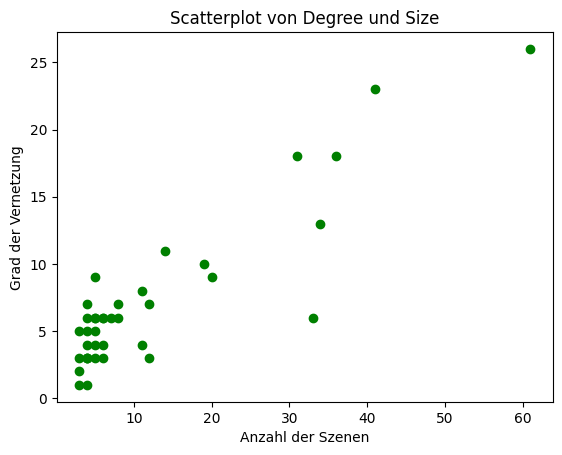

In [32]:
degrees = dict(graph_first_episode.degree())
values = nx.get_node_attributes(graph_first_episode, 'size')

degree_list = [degrees[node] for node in graph_first_episode.nodes()]
value_list = [values[node] for node in graph_first_episode.nodes()]

original_correlation, _ = pearsonr(degree_list, value_list)
print("Die originale Korrelation beträgt:", round(original_correlation,3))

plt.scatter(value_list, degree_list, color='green')
plt.title('Scatterplot von Degree und Size')
plt.ylabel('Grad der Vernetzung')
plt.xlabel('Anzahl der Szenen')
plt.show()

Die Pearson Korrelation zwischen dem Degree und der Anzahl Szenen ist mit 0.89 relativ, es gibt also einen Zusammenhang zwischen diesen beiden Variablen. Im Scatterplot wird allerdings ersichtlich, dass viele Charakteren in weniger als 10 Szenen auftauchen, der Degree aber von 1 bis 10 reicht. In der Praxis müsste man die Korrelation genauer untersuchen (Stichwort Scheinkorrelation und Ausreisser). Um die Funktionsweise des Hypothesentests aufzuzeigen, gehen wir hier davon aus, dass die Korrelation korrekt ist.

Nun führen wir die Permutation durch. Wir führen dazu 50'000 Permutationen durch und vermischen dabei immer die Werte in beiden Vektoren.

In [33]:
np.random.seed(42)

num_permutations = 50_000
significance_level = 0.05
count_greater = 0

lst_new_correlations = []

for _ in range(num_permutations):
    np.random.shuffle(value_list)
    np.random.shuffle(degree_list)
    permuted_correlation, _ = pearsonr(degree_list, value_list)
    lst_new_correlations.append(permuted_correlation)
    if permuted_correlation >= original_correlation:
        count_greater += 1

print("Anzahl neuer Korrelationen, die grösser sind:", count_greater)

p_value = count_greater / num_permutations

print("Der p-Wert beträgt:", p_value)

Anzahl neuer Korrelationen, die grösser sind: 0
Der p-Wert beträgt: 0.0


In den 50'000 Permutationen ist keine Korrelatioen höher als der originale Wert von 0.893. Das ist zwar eher überraschend, doch gemäss Definition können wir unsere Hypothese bestätigten, es gibt einen signifikanten Zusammenhang zwischen der Anzahl Szenen, in denen ein Charakter vorkommt und dessen Degree.

Aus Interesse plotten wir nun noch ein Histogramm, das die Verteilung der berechnete neuen Korrelationen aufzeigt und sie mit dem originalen Wert vergleicht.

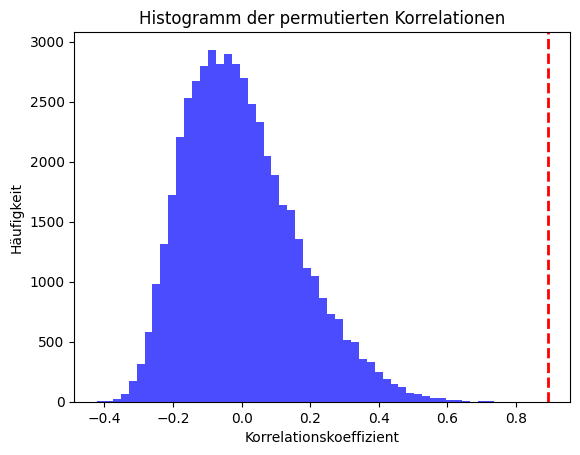

In [34]:
plt.hist(lst_new_correlations, bins=50, color='blue', alpha=0.7)
plt.axvline(x=original_correlation, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogramm der permutierten Korrelationen')
plt.xlabel('Korrelationskoeffizient')
plt.ylabel('Häufigkeit')
plt.show()

Dieses Histogramm bestätigt, dass der originale Korrelationskoeffizient deutlich höher als die neuen, aus der Permutation berechneten, Werte liegt und bestätigt visuell die Annahme der Hypothese.

# 9 Ausblick

Sehr wichtig! 